In [19]:
# TCC: 
# Code: 
# Author: Anísio Pereira Batista Filho

In [20]:
##Essentials
import os
import csv
import numpy as np ##Numpy
import pandas as pd ##Pandas
##Matplotlib
import matplotlib
import matplotlib.pyplot as plt
##Ekphrasis
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons
##NLTK
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
##Cogroo4py
#from utils.cogroo4py.cogroo_interface import cogroo
##Cogroo-Interface
#from cogroo_interface import Cogroo
#cogroo = Cogroo.Instance()
from cogroo4py.cogroo import Cogroo
cogroo = Cogroo()
##Spellchecker
from spellchecker import SpellChecker
##Wordcloud
from wordcloud import WordCloud, ImageColorGenerator
##Utils
import re
import unicodedata
from tqdm.auto import tqdm
import time
import timeit

In [21]:
start = timeit.default_timer()

In [22]:
##Spell checker:
def spellchecker_pt(df, rowname):
    print('-Início do spellchecker_pt-')
    spell = SpellChecker(language='pt')
    correction_list = []
    for index, row in tqdm(df.iterrows(),total=df.shape[0]):
        correction = spell.correction(row[rowname])
        correction_list.append(correction)

    return correction_list


In [23]:
##Converter caracteres de tweet_text para 'lower case':
def lowercase_converter(df, rowname):
    print('-Início do lowercase_Converter-')
    tweet_text_lower = []
    for index, row in tqdm(df.iterrows(),total=df.shape[0]):
        lower_row = row[rowname].lower()
        tweet_text_lower.append(lower_row)

    return tweet_text_lower

In [24]:
##Pre-processamento de texto com Ekphrasis:
def preproc_ekphrasis(df, rowname):
    print('-Início do preproc_ekphrasis-')
    text_processor = TextPreProcessor(
        # terms that will be normalized
        normalize=['url', 'email', 'percent', 'money', 'phone', 'user',
            'time', 'url', 'date', 'number'],
        # terms that will be annotated
        annotate={"hashtag", "allcaps", "elongated", "repeated",
            'emphasis', 'censored'},
        fix_html=True,  # fix HTML tokens
        
        # corpus from which the word statistics are going to be used 
        # for word segmentation 
        segmenter="twitter", 
        
        # corpus from which the word statistics are going to be used 
        # for spell correction
        corrector="twitter", 
        
        unpack_hashtags=True,  # perform word segmentation on hashtags
        unpack_contractions=False,  # Unpack contractions (can't -> can not)
        spell_correct_elong=False,  # spell correction for elongated words
        
        # select a tokenizer. You can use SocialTokenizer, or pass your own
        # the tokenizer, should take as input a string and return a list of tokens
        tokenizer=SocialTokenizer(lowercase=True).tokenize,
        
        # list of dictionaries, for replacing tokens extracted from the text,
        # with other expressions. You can pass more than one dictionaries.
        dicts=[emoticons]
    )

    preproc_list = []
    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        line = row[rowname]
        #print(" ".join(text_processor.pre_process_doc(line)))
        preproc_list.append(" ".join(text_processor.pre_process_doc(line)))
        #print(preproc_list)

    return preproc_list

In [25]:
##Remoção de Stopwords utilizando NLTK:
def stopwords_ntlk(preproc_list = []):
    print('-Início do stopwords_nltk-')
    stopWords = nltk.corpus.stopwords.words('portuguese')
    stopwords_list = []
    for line in tqdm(preproc_list, total=len(preproc_list)):
        words = word_tokenize(line, language='portuguese')
        sent = []
        for w in words:
            if w not in stopWords:
                sent.append(w)
        sent_str = " ".join(sent)
        stopwords_list.append(sent_str)

    #print(stopwords_list)
    return stopwords_list

In [26]:
##Remoção de símbolos:
def symbol_remover(stopwords_list = []):
    print('-Início do symbol_remover-')
    symboless_list = []
    for line in tqdm(stopwords_list, total=len(stopwords_list)):
        # Unicode normalize transforma um caracter em seu equivalente em latin.
        nfkd = unicodedata.normalize('NFKD', line)
        new_line = u"".join([c for c in nfkd if not unicodedata.combining(c)])
        # Usa expressão regular para retornar a palavra apenas com números, letras e espaço
        symboless_line = re.sub('[^a-zA-Z0-9 \\\\]', ' ', new_line)
        symboless_line = " ".join(symboless_line.split())
        if symboless_line.strip():
            symboless_list.append(symboless_line)
        #print(line)

    return symboless_list

In [27]:
##Substituição de palavras:
def wordreplacer(symboless_list = []):
    print('-Início do wordreplacer-')
    ###Abertura de arquivos e criação de dataframes:
    abreviações_internet_file = pd.read_csv("data/utils/abreviações_internet.csv")
    abreviações_estados_file = pd.read_csv("data/utils/abreviações_estados.csv")
    flexões_vacina_file = pd.read_csv("data/utils/flexões_vacinar.csv")
    df_internet = pd.DataFrame(abreviações_internet_file)
    df_estados = pd.DataFrame(abreviações_estados_file)
    df_vacinar = pd.DataFrame(flexões_vacina_file)

    ###Criação de listas de substituição:
    covidReplace = [ 'covid', 'covid-19', 'covid19', 'coronavirus', 'corona', 'virus' ]
    vacinaReplace = [ 'coronavac', 'astrazeneca', 'pfizer', 'sputnik v', 'sputnik', 
                    'sinovac', 'oxford', 'moderna', 'butantan', 'johnson', 
                    'johnson&johnson', 'jnj', 'fio cruz', 'fiocruz' 
                    ]
    ab_internet = dict()
    for row in tqdm(df_internet.itertuples(), total=df_internet.shape[0]):
        ab_internet[row.sigla] = row.significado

    ab_estados = dict()
    for row in tqdm(df_estados.itertuples(), total=df_estados.shape[0]):
        ab_estados[row.sigla] = row.estado

    ab_vacinar = []
    for row in tqdm(df_vacinar.itertuples(), total=df_vacinar.shape[0]):
        ab_vacinar.append(row[0])

    ###Substituindo palavras:
    wordreplaced_list = []
    for line in tqdm(symboless_list, total=len(symboless_list)):
        words = word_tokenize(line, language='portuguese')
        #line = " ".join(line.split())
        sent = []
        for word in words:
            if word in ab_internet:
                word = word.replace(word, ab_internet[word])
            if word in ab_estados:
                word = word.replace(word, ab_estados[word])
            if word in ab_vacinar:
                word = word.replace(word, 'vacina')
            if word in covidReplace:
                word = word.replace(word, 'covid')            
            if word in vacinaReplace:
                word = word.replace(word, 'vacina')
            sent.append(word)
        #line = " ".join(word)
        sent_str = " ".join(sent)
        wordreplaced_list.append(sent_str)
    #print (wordreplaced_list)
    return wordreplaced_list

In [28]:
##Remoção de palavras:
def wordremover(wordreplaced_list = []):
    print('-Início do wordremover-')
    ###Abertura de arquivo e criação de dataframe:
    stopwords_internet_file = pd.read_csv("data/utils/stopwords_internet_symboless.csv")
    df_stopwords = pd.DataFrame(stopwords_internet_file)

    ###Criação da lista de stopwords:
    sw_internet = []
    for row in tqdm(df_stopwords.itertuples(), total=df_stopwords.shape[0]):
        sw = row.stopwords
        sw = "".join(re.split(r"\s+", sw))
        sw_internet.append(sw)

    ###Removendo palavras:
    wordremoved_list = []
    for line in tqdm(wordreplaced_list, total=len(wordreplaced_list)):
        words = word_tokenize(line, language='portuguese')
        #line = " ".join(line.split())
        sent = []
        for word in words:
            if word not in sw_internet:
                sent.append(word)
        sent_str = " ".join(sent)
        wordremoved_list.append(sent_str)
    #print(wordremoved_list)
    return wordremoved_list


In [29]:
##Stemming utilizando NLTK:
def stemming_nltk(wordremoved_list = []):
    print('-Início do stemming_nltk-')
    stemmer = nltk.stem.RSLPStemmer()
    stemmed_list = []
    for line in tqdm(wordremoved_list, total=len(wordremoved_list)):
        #line = " ".join(line.split())
        words = word_tokenize(line, language='portuguese')
        sent = []
        for word in words:
            sent.append(stemmer.stem(word))
        sent_str = " ".join(sent)
        stemmed_list.append(sent_str)

    return stemmed_list


In [30]:
##Lemmatization utilizando Cogroo4py:
def lemmatization_cogroo4py(wordremoved_list = []):
    print('-Início do lemmatization_cogroo4py-')
    lemmatized_list = []
    for line in tqdm(wordremoved_list, total=len(wordremoved_list)):
        #line = " ".join(line.split())
        #line = cogroo.lemmatize(line)
        #line = line.lower()
        words = word_tokenize(line, language='portuguese')
        sent = []
        for word in words:
            sent.append(cogroo.lemmatize(word).lower())
        sent_str = " ".join(sent)
        lemmatized_list.append(sent_str)

    return lemmatized_list


In [31]:
##Contador de frequência de palavras:
def wordfrequency(word_list= []):
    print('-Início do wordfrequency-')
    wordstring = " ".join(word_list)
    wordlist = wordstring.split()
    wordfreq = []
    wordfreq = [wordlist.count(p) for p in tqdm(wordlist, total=len(wordlist))]
    freqdict = dict(list(zip(wordlist,wordfreq)))
    sorteddict = dict(sorted(freqdict.items(), key=lambda t: t[1], reverse=True))

    frequency_list = []
    for s in tqdm(sorteddict.items(), total=len(sorteddict)): 
        #print(str(s))
        frequency_list.append(str(s))

    return frequency_list


In [32]:
##Criação de wordcloud:
def wordcloud_generator(word_list = []):
    print('-Início do wordcloud_generator-')
    all_summary = " ".join(word_list)
    wordcloud = WordCloud(
                      background_color='black', 
                      width=1600,                            
                      height=800).generate(all_summary)
    fig, ax = plt.subplots(figsize=(16,8))
    ax.imshow(wordcloud, interpolation='bilinear')       
    ax.set_axis_off()
    plt.imshow(wordcloud) 
    
    return wordcloud                
    #wordcloud.to_file('testcloud.png')

In [33]:
def preproc_original(df):
    ####Pré-processamento de texto e criação de colunas:
    lower_list = lowercase_converter(df, 'tweet_text')
    try:
        df.insert(4, 'tweet_text_lower', lower_list)
    except:
        df['tweet_text_lower'] = lower_list
    preproc_list = preproc_ekphrasis(df, 'tweet_text_lower')
    stopwords_list = stopwords_ntlk(preproc_list)
    symboless_list = symbol_remover(stopwords_list)
    wordreplaced_list = wordreplacer(symboless_list)
    wordremoved_list = wordremover(wordreplaced_list)
    stemmed_list = stemming_nltk(wordremoved_list)
    try:
        df.insert(5, 'tweet_text_stemmed', stemmed_list)
    except:
        df['tweet_text_stemmed'] = stemmed_list
    lemmatized_list = lemmatization_cogroo4py(wordremoved_list)
    try:
        df.insert(6, 'tweet_text_lemmatized', lemmatized_list)
    except:
        df['tweet_text_lemmatized'] = lemmatized_list
    stemmed_frequency = wordfrequency(stemmed_list)
    lemmatized_frequency = wordfrequency(lemmatized_list)

    ####Geração de wordclouds:
    stemmed_cloud = wordcloud_generator(stemmed_frequency)
    stemmed_cloud.to_file("data/corpus_labeled/iguais/rotulacao_uniao[iguais]_stemmcloud.png")
    lemmatized_cloud = wordcloud_generator(lemmatized_frequency)
    lemmatized_cloud.to_file("wordcloud/corpus_labeled/iguais/rotulacao_uniao[iguais]_lemmacloud.png")

    return


In [34]:
def preproc_spellchecked(df):
    spellchecked_list = spellchecker_pt(df, 'tweet_text')
    try:
        df.insert(4, 'tweet_text_spellchecked', spellchecked_list)
    except:
        df['tweet_text_spellchecked'] = spellchecked_list
    lower_list = lowercase_converter(df, 'tweet_text_spellchecked')
    try:
        df.insert(5, 'tweet_text_spellchecked_lower', lower_list)
    except:
        df['tweet_text_spellchecked_lower'] = lower_list
    preproc_list = preproc_ekphrasis(df, 'tweet_text_spellchecked_lower')
    stopwords_list = stopwords_ntlk(preproc_list)
    symboless_list = symbol_remover(stopwords_list)
    wordreplaced_list = wordreplacer(symboless_list)
    wordremoved_list = wordremover(wordreplaced_list)
    stemmed_list = stemming_nltk(wordremoved_list)
    try:
        df.insert(6, 'tweet_text_spellchecked_stemmed', stemmed_list)
    except:
        df['tweet_text_spellchecked_stemmed'] = stemmed_list
    lemmatized_list = lemmatization_cogroo4py(wordremoved_list)
    try:
        df.insert(7, 'tweet_text_spellchecked_lemmatized', lemmatized_list)
    except:
        df['tweet_text_spellchecked_lemmatized'] = lemmatized_list
    stemmed_frequency = wordfrequency(stemmed_list)
    lemmatized_frequency = wordfrequency(lemmatized_list)

    ####Geração de wordclouds:
    stemmed_cloud = wordcloud_generator(stemmed_frequency)
    stemmed_cloud.to_file("wordcloud/corpus_labeled/iguais/rotulacao_uniao[iguais]_spellchecked_stemmcloud.png")
    lemmatized_cloud = wordcloud_generator(lemmatized_frequency)
    lemmatized_cloud.to_file("wordcloud/corpus_labeled/iguais/rotulacao_uniao[iguais]_spellchecked_lemmacloud.png")

    return


-Início do spellchecker_pt-


  0%|          | 0/3600 [00:00<?, ?it/s]

-Início do lowercase_Converter-


  0%|          | 0/3600 [00:00<?, ?it/s]

-Início do preproc_ekphrasis-
Word statistics files not found!
Downloading... 

C:\Users\anisi\.conda\envs\pivic37\lib\site-packages\ekphrasis\classes\tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


done!
Unpacking... done!
Reading twitter - 1grams ...
generating cache file for faster loading...
reading ngrams C:\Users\anisi\.ekphrasis\stats\twitter\counts_1grams.txt
Reading twitter - 2grams ...
generating cache file for faster loading...
reading ngrams C:\Users\anisi\.ekphrasis\stats\twitter\counts_2grams.txt
Reading twitter - 1grams ...


C:\Users\anisi\.conda\envs\pivic37\lib\site-packages\ekphrasis\classes\exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


  0%|          | 0/3600 [00:00<?, ?it/s]

-Início do stopwords_nltk-


  0%|          | 0/3600 [00:00<?, ?it/s]

-Início do symbol_remover-


  0%|          | 0/3600 [00:00<?, ?it/s]

-Início do wordreplacer-


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

-Início do wordremover-


  0%|          | 0/289 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

-Início do stemming_nltk-


  0%|          | 0/3600 [00:00<?, ?it/s]

-Início do lemmatization_cogroo4py-


  0%|          | 0/3600 [00:00<?, ?it/s]

-Início do wordfrequency-


  0%|          | 0/46837 [00:00<?, ?it/s]

  0%|          | 0/5451 [00:00<?, ?it/s]

-Início do wordfrequency-


  0%|          | 0/47191 [00:00<?, ?it/s]

  0%|          | 0/6628 [00:00<?, ?it/s]

-Início do wordcloud_generator-
-Início do wordcloud_generator-


FileNotFoundError: [Errno 2] No such file or directory: 'data/data-twitter/training/rotulaçao_uniao[iguais]_preproc.csv'

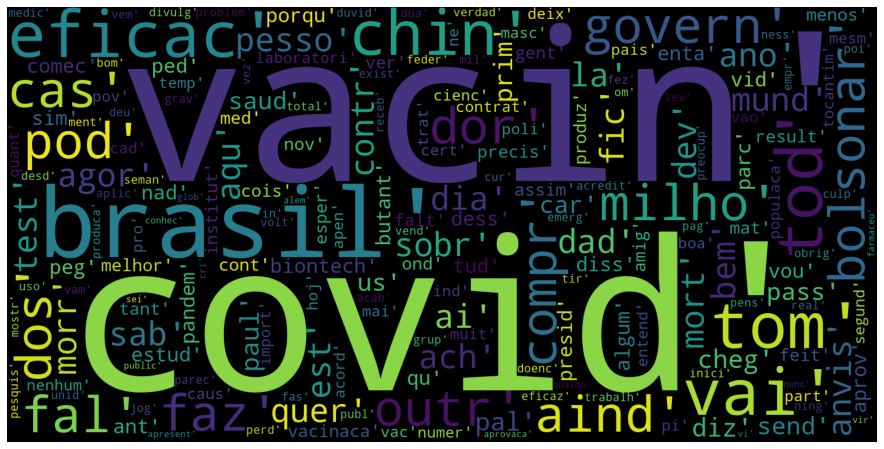

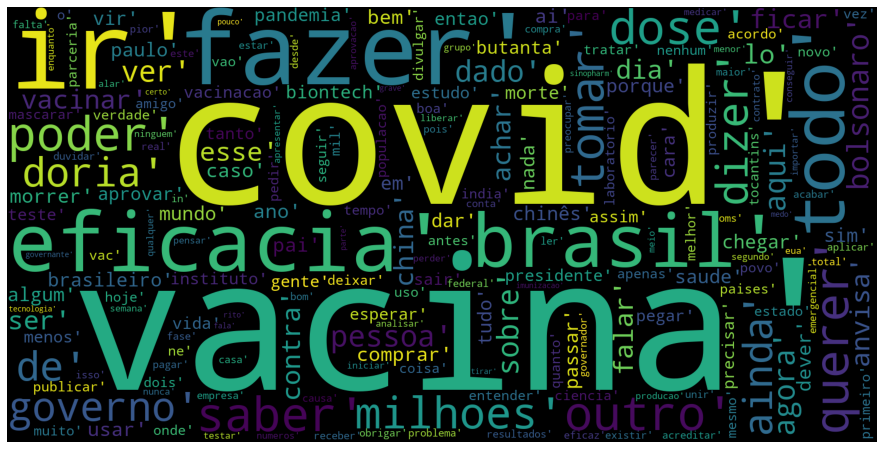

In [35]:
##Função main:
###Abertura de arquivo e criação do dataframe:
#df_file = pd.read_csv("data/data-twitter/training/rotulaçao[iguais].csv", sep=",")
#df = pd.DataFrame(df_file)
#df = df.drop_duplicates(subset='tweet_id', keep='first')

df_file = pd.read_csv("data/corpus_labeled/iguais/rotulacao_uniao[iguais].csv", sep=",")
df = pd.DataFrame(df_file)
#df = df.drop_duplicates(subset='tweet_id', keep='first')

###Chamadas de funções:
####Pré-processamento de texto e criação de colunas:
#preproc_original(df)
preproc_spellchecked(df)

###Salvando alterações no csv:
add_file = df.to_csv("data/corpus_labeled/iguais/rotulacao_uniao[iguais]_preproc.csv", sep=",", index=False)


In [36]:
add_file = df.to_csv("data/corpus_labeled/iguais/rotulacao_uniao[iguais]_preproc.csv", sep=",", index=False)

In [ ]:
end = timeit.default_timer()
print ('Duração: %f' % (end - start))